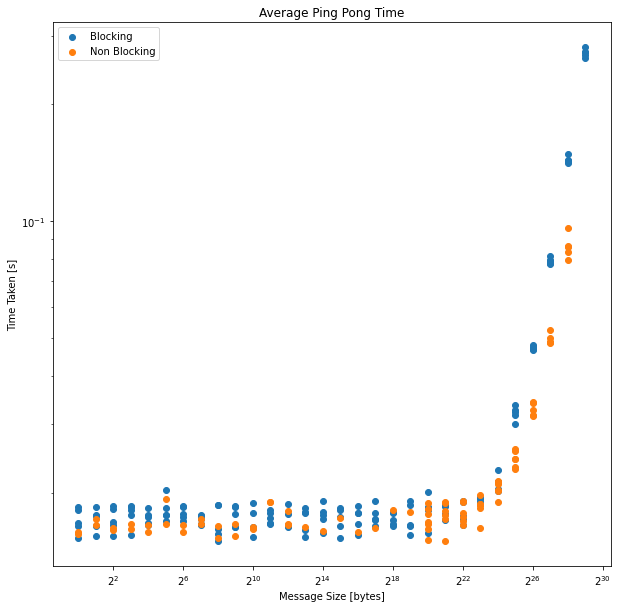

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns 
import subprocess
import pandas as pd
import numpy as np

header = ['Processors', 'Message Size', 'Time Taken']
################################################################
#Blocking Data
data_b = pd.read_csv('ping_pong_blocking.csv', header=0)
data_b.columns = header
data_b.head()

processors_b = data_b['Processors']
messageSize_b = data_b['Message Size']
time_b = data_b['Time Taken']
iterations = 100

avgCommunicationTime_b = time_b / iterations

################################################################
#non- blocking Data
data_nb = pd.read_csv('ping_pong_nonblocking.csv', header=0)
data_nb.columns = header
data_nb.head()

processors_nb = data_nb['Processors']
messageSize_nb = data_nb['Message Size']
time_nb = data_nb['Time Taken']
iterations = 100

avgCommunicationTime_nb = time_nb / iterations
################################################################

plt.figure(figsize=(10,10))
plt.scatter(messageSize_b, avgCommunicationTime_b,label = 'Blocking')
plt.scatter(messageSize_nb,avgCommunicationTime_nb,label = 'Non Blocking')
plt.xscale('log', base=2)
plt.yscale('log')
plt.title('Average Ping Pong Time')
plt.xlabel('Message Size [bytes]')
plt.ylabel('Time Taken [s]')
plt.legend()
plt.show()

[[0.77715074]]


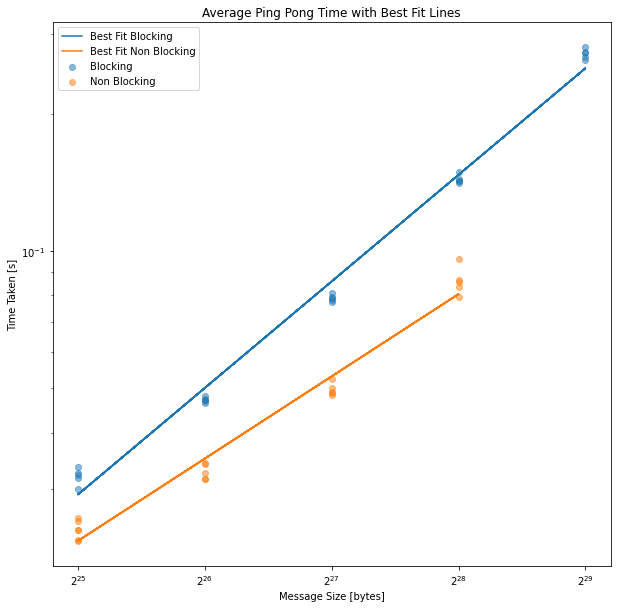

In [22]:
# Approximate Latency

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


# Load data (Replace this with the actual CSV file loading in the execution environment)
high_data_b = data_b[data_b['Message Size']>= 2**25]
high_data_nb = data_nb[data_nb['Message Size']>= 2**25]

# Extracting necessary columns and computing average communication time
avgCommunicationTime_b = high_data_b['Time Taken'] / 100  # Assuming 100 iterations for average
avgCommunicationTime_nb = high_data_nb['Time Taken'] / 100  # Assuming 100 iterations for average

# Transforming message sizes and time taken to a logarithmic scale to linearize exponential growth
log_messageSize_b = np.log2(high_data_b['Message Size'])
log_avgCommunicationTime_b = np.log2(avgCommunicationTime_b)
log_messageSize_nb = np.log2(high_data_nb['Message Size'])
log_avgCommunicationTime_nb = np.log2(avgCommunicationTime_nb)

# Fit a linear model to the data
# For blocking
model_b = LinearRegression()
model_b.fit(log_messageSize_b.values.reshape(-1, 1), log_avgCommunicationTime_b.values.reshape(-1, 1))

print(model_b.coef_)

# For non-blocking
model_nb = LinearRegression()
model_nb.fit(log_messageSize_nb.values.reshape(-1, 1), log_avgCommunicationTime_nb.values.reshape(-1, 1))

# Predicting the best fit line
best_fit_b = model_b.predict(log_messageSize_b.values.reshape(-1, 1))
best_fit_nb = model_nb.predict(log_messageSize_nb.values.reshape(-1, 1))

# Plotting the scatter data and best fit line
plt.figure(figsize=(10,10))
plt.scatter(high_data_b['Message Size'], avgCommunicationTime_b, label='Blocking', alpha=0.5)
plt.scatter(high_data_nb['Message Size'], avgCommunicationTime_nb, label='Non Blocking', alpha=0.5)
plt.plot(high_data_b['Message Size'], 2**best_fit_b.flatten(), label='Best Fit Blocking')
plt.plot(high_data_nb['Message Size'], 2**best_fit_nb.flatten(), label='Best Fit Non Blocking')
plt.xscale('log', base=2)
plt.yscale('log')
plt.title('Average Ping Pong Time with Best Fit Lines')
plt.xlabel('Message Size [bytes]')
plt.ylabel('Time Taken [s]')
plt.legend()
plt.show()


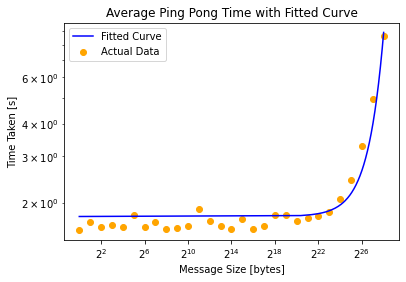

In [5]:
from scipy.optimize import curve_fit

# Define the exponential function for curve fitting.
def exponential_func(x, a, b):
    return a * np.exp(b * x)

# Simulated message sizes and average times (this would be replaced with actual data)
np.random.seed(0)
message_sizes = data_b['Message Size'].unique()
avg_times = data_b.groupby('Message Size')['Time Taken'].mean()

# print(message_sizes)
# print(avg_times)

initial_guess = [max(avg_times), 0]

# Perform the curve fitting
params, covariance = curve_fit(exponential_func, message_sizes, avg_times, p0=initial_guess)

# Extract the parameters a and b from the fit
a, b = params

# The intercept (latency) is the value of 'a', as e^0 is 1
intercept = a

# Generate a sequence of message sizes for plotting the curve
message_size_plot = np.linspace(min(message_sizes), max(message_sizes), 200)
# Compute the fitted curve values
fitted_curve = exponential_func(message_size_plot, *params)

# Plot the actual data points
plt.scatter(message_sizes, avg_times, label='Actual Data', color='orange')

# Plot the fitted curve
plt.plot(message_size_plot, fitted_curve, label='Fitted Curve', color='blue')

plt.title('Average Ping Pong Time with Fitted Curve')
plt.xlabel('Message Size [bytes]')
plt.ylabel('Time Taken [s]')
plt.xscale('log',base=2)
plt.yscale('log')
plt.legend()
plt.show()


(200, 1)
Latency Prediction = [1.64304077]


/opt/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


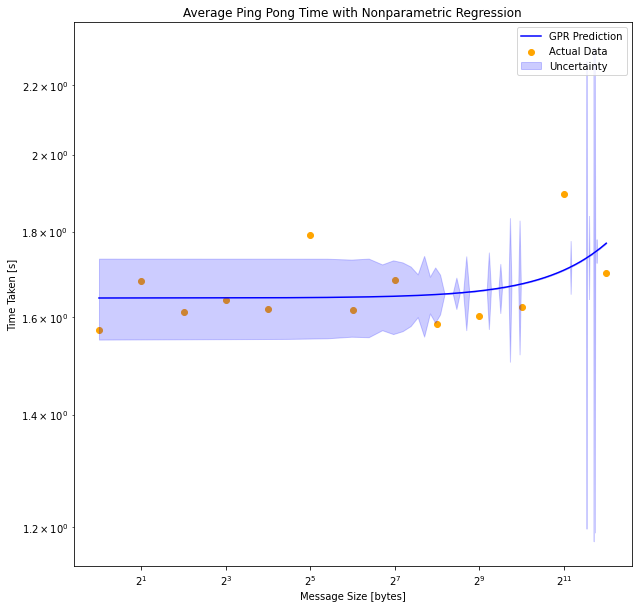

In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

# Since we don't have the actual data from data_b, we will simulate it for illustration purposes.
message_sizes = data_b['Message Size'].unique()
avg_times = data_b.groupby('Message Size')['Time Taken'].mean()

low_message_size_data = data_b[data_b['Message Size']<=4096]
low_message_sizes = low_message_size_data['Message Size'].unique()
low_avg_times = low_message_size_data.groupby('Message Size')['Time Taken'].mean()

# Gaussian Process Regression with a DotProduct kernel for nonparametric regression
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, random_state=0)

# Fit to data using Gaussian Process Regressor
gpr.fit(low_message_sizes.reshape(-1, 1), low_avg_times)

# Predict using Gaussian Process Regressor
message_size_plot = np.linspace(min(low_message_sizes), max(low_message_sizes), 200).reshape(-1, 1)

print(message_size_plot.shape)
gpr_pred, gpr_sigma = gpr.predict(message_size_plot, return_std=True)

latency_pred = gpr.predict([[0]])

print(f"Latency Prediction = {latency_pred}")

# Plot the actual data points
plt.figure(figsize=(10,10))
plt.scatter(low_message_sizes, low_avg_times, label='Actual Data', color='orange')

# Plot the Gaussian Process Regression prediction
plt.plot(message_size_plot, gpr_pred, label='GPR Prediction', color='blue')

# Plot uncertainty bounds as a shaded region
plt.fill_between(message_size_plot.flatten(), gpr_pred - gpr_sigma, gpr_pred + gpr_sigma, color='blue', alpha=0.2, label='Uncertainty')

plt.title('Average Ping Pong Time with Nonparametric Regression')
plt.xlabel('Message Size [bytes]')
plt.ylabel('Time Taken [s]')
plt.xscale('log',base=2)
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
header = ['Processors', 'Message Size', 'Time Taken']
################################################################
#Blocking Data
data_b = pd.read_csv('ring_shift_blocking.csv', header=0)
data_b.columns = header
data_b.head()

processors_b = data_b['Processors']
messageSize_b = data_b['Message Size']
time_b = data_b['Time Taken']
iterations = 100

avgCommunicationTime_b = time_b / iterations

################################################################
#non- blocking Data
data_nb = pd.read_csv('ring_shift_nonblocking.csv', header=0)
data_nb.columns = header
data_nb.head()

processors_nb = data_nb['Processors']
messageSize_nb = data_nb['Message Size']
time_nb = data_nb['Time Taken']
iterations = 100

avgCommunicationTime_nb = time_nb / iterations
################################################################

plt.figure()
plt.scatter(messageSize_b, avgCommunicationTime_b,label = 'Blocking')
plt.scatter(messageSize_nb,avgCommunicationTime_nb,label = 'Non Blocking')
plt.xscale('log', base=2)
plt.yscale('log')
plt.title('Average Ping Pong Time')
plt.xlabel('Message Size [bytes]')
plt.ylabel('Time Taken [s]')
plt.legend()
plt.show()

EmptyDataError: No columns to parse from file